<a href="https://colab.research.google.com/github/Dju97/Cats-and-dogs-recognition/blob/master/CatsAndDogsRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognizing dogs and cats

The purpose of this project is to build a first end to end reflex-based AI model to teach computers to [**understand images**](https://www.ted.com/talks/fei_fei_li_how_we_re_teaching_computers_to_understand_pictures).

In particular, the objective of this project is to write an AI application able to recognize cats and dogs on images. My application take an image as input and is able to say wheter the image contains a dog or a cat. I worked with the data of the [**Dogs vs Cats**](https://www.kaggle.com/c/dogs-vs-cats) competition from Kaggle. This competition was launched in 2013 and the first place was obtained by [Pierre Sermanet](https://research.google.com/pubs/PierreSermanet.html), actually Research Scientist at Google Brain, by using the [Overfeat](http://cilvr.nyu.edu/doku.php?id=software:overfeat:start#overfeatobject_recognizer_feature_extractor) deep learning library he wrote during his PhD at New York University under the supervision of [Yann Le Cun](http://yann.lecun.com/), Director of AI Research at Facebook. He obtained $1.09%$ of classification errors.

Two approaches has been used to adress this problem :
1. A traditional pattern recognition model in which hand-crafted features are extracted from images and used to represent them and to train classifiers. This was just for testing since I know it's less performing than CNN, thus I haven't past much time to optimize these methods.
2. A modern representation learning approach in which deep convolutional neural networks (CNN) are used to learn the image representations.

    

## Part 0 : Requirements
A set of packages will be useful to handle the first part of this study case.

    pip3 install -r requirements.txt

## Part 1 : A small introduction to image classification

In this section, I introduced the image classification problem which consists in assigning to an input image one label from a fixed set of labels and which is one of the big challenge of computer vision and artifial intelligence. In our case, we will only consider two labels $\{dog, cat\}$. This small part also aims at familiarizing me with computer vision librairies that I used in this course :
+ OpenCV : [http://opencv.org/](http://opencv.org/) or Scikit-image ([http://scikit-image.org/](http://scikit-image.org/)










### A simple image classification pipeline

To built my image classification algorithm, I have followed the principle of a machine learning approach for image classification which consists in :
1. Collecting and preparing a dataset of images and their corresponding labels.
2. Using a machine learning algorithm to train a classifier.
3. Evaluate the classifier on new images.


#### Having a look on the available data

First, I've have downloaded the dataset that has been used to train and test my model. You'll find the dataset in the data folder.This dataset contains 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for the Kaggle competition.

As usual, the standard practice in machine learning is to split the available data into three different subsets :
+ The **training set** : to learn the model.
+ The **validation set** : to fine-tune the parameters of the model
+ The **testing set** : to evaluate the learned model.

In our case, the preparation of the data has been done and that the test and train sets are in separate subdirectories in which data for each category (cats and dogs) is also into subdirectories. Nevertheless, there is no validation set and I then had to build one myself.

The archive also contains a directory named sampleDeep I've generated taking random pictures from the training data set. Since training and validating the entire dataset can take some time, it is a good practice to run algorithm on a small sample of your training and validation data before to run it on the entire set of data.


##### Image representation

I first wanted to try methods without using deep learning and using older algorithms. I then tried task to built a representation of the data, i.e. a feature vector which values quantify the contents of the image. I then searched documentation on what could be meaningful. Here, I just represented the images by two alternative representations to compare them.
+ A first representation is built using the raw data by simply resizing an input image to a fixed size (here $32 \times 32$ pixels)and then by flattening the RBG pixel intensities into a single vectors of numbers.
+ A second representation is built from the color histogram that characterizes the color distribution of the image. For this representation a color conversion into the HSV color space could be useful.
    

In [0]:
import numpy as np
from skimage import data,transform,io,color
import pandas as pd

def image_to_feature_vector(image, size=(32, 32)):
    # resize the image to a fixed size, then flatten the image into a list of raw pixel intensities
    res  = transform.resize(image,size)
    res = res.flatten()
    return list(res)


def build_HSV_color_histogram_vector(image,bins=(8, 8, 8)):
    # extract a 3D color histogram from the HSV color space using the supplied number of `bins` per channel and return it as a feature vector
    res = color.convert_colorspace(image,'RGB','HSV')
    results = []
    for i,bin1 in enumerate(bins):
        results.extend(np.histogram(res[:,:,i],bin1)[0])
    return results

#### Dataset prepatation and feature extraction
The dataset has to be prepared for feature extraction :
+ Three lists will be initialized to store the raw pixel representation, the color distribution (histogram) representation and the class labels themselves.
+ Then, the lists will be completed by extracted the features from the dataset (don't forgot to begin by testing your program on the sample dataset before to apply it on the whole dataset).

For this step, we can used the paths.py file [here](https://github.com/jrosebr1/imutils/blob/master/imutils/paths.py) from imutils




In [0]:
from imutils import paths
from random import shuffle
print("Describing images...")
imagePaths = list(paths.list_images('./sampleDeep/train'))
shuffle(imagePaths)

# initialize the raw pixel intensities matrix, the features matrix and labels list
rawImages_features = []
histogram_features = []
labels = []
# we take only 200 images to test our representations
for imagePath in imagePaths[:300]:
    rawImages_features.append(image_to_feature_vector(io.imread(imagePath)))
    histogram_features.append(build_HSV_color_histogram_vector(io.imread(imagePath)))
    if 'cats' in imagePath:
        labels.append(0)
    else:
        labels.append(1)
    

Describing images...


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


#### Dataset splitting into training and validation dataset

The last step will be to split the training dataset into training dataset and validation dataset.

In [0]:
from sklearn.model_selection import train_test_split
# TO COMPLETE
Raw_train,Raw_test,Hist_train,Hist_test,y_train,y_test =  train_test_split(rawImages_features,histogram_features,labels)


#### Classification using the K-Nearest Neighbor (KNN) classifier


In order to build this simple image classification pipeline, I tried using the k-Nearest Neighbor (KNN) classifier which is a very simple machine learning/image classification approach, even if it's rarely used in practice, its simplicity has enabled me to get quickly an idea of the image classification pipeline. I then firstly tried to build a very simple model, without tuning hyper parameters and using the euclidian metric for simplicity :

$d(p,q)=\sqrt{\sum_{i=1}^{N}(q_i-p_i)^2}$


In [0]:
from sklearn.neighbors import KNeighborsClassifier

# training and evaluation of a k-NN classifer on the raw pixel representation
neigh = KNeighborsClassifier(n_neighbors = 10)
neigh.fit(Raw_train,y_train)
print("Raw pixel representation accuracy:")
print(neigh.score(Raw_train,y_train))
# training and evaluation of  a k-NN classifer on the color histogram representation
neigh = KNeighborsClassifier(n_neighbors = 10)
neigh.fit(Hist_train,y_train)
print("Color histogram representation accuracy:")
print(neigh.score(Hist_train,y_train))


Raw pixel representation accuracy:
0.5911111111111111
Color histogram representation accuracy:
0.64


**I then obtained the following scores without tuning hyperparameters**

1.   For raw data representation : 0.59
2.   For historigram : 0.64

These results are a little better than random prediction, and are quite good since the simplicity of the data representations and the model.




#### Cross-validation

I've used cross-validation to hypertune parameters, in particularly the number of neighbors optimal, searching in a range from 1 to 29.

 10-fold cross validation on the KNN classifier with raw features
Plotting the misclassification error versus k
The optimal number of neighbors is 5


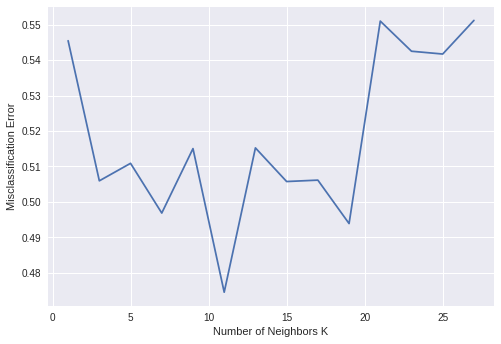

 10-fold cross validation on the KNN classifier with hist features
Plotting the misclassification error versus k


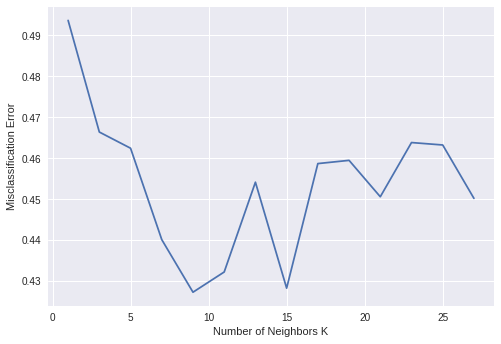

The optimal number of neighbors is 4


In [0]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


# creating odd list of K for KNN
params = {"n_neighbors": np.arange(1, 29, 2)}

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation on the KNN classifier with raw features
print(" 10-fold cross validation on the KNN classifier with raw features")
for k in params["n_neighbors"]:
    neigh = KNeighborsClassifier(n_neighbors=k)
    cv_scores.append(np.mean(cross_val_score(neigh,Raw_train,y_train,cv=10)))

print("Plotting the misclassification error versus k")
# changing to misclassification error
MSE = [1 - x for x in cv_scores]


# determining best k
optimal_k =0
for k,result in enumerate(cv_scores):
    if result > cv_scores[optimal_k]:
        optimal_k = k
        
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(params["n_neighbors"], MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()



# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation on the KNN classifier with raw features
print(" 10-fold cross validation on the KNN classifier with hist features")

for k in params["n_neighbors"]:
    neigh = KNeighborsClassifier(n_neighbors=k)
    cv_scores.append(np.mean(cross_val_score(neigh,Hist_train,y_train,cv=10)))
    
print("Plotting the misclassification error versus k")
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k =0
for k,result in enumerate(cv_scores):
    if result > cv_scores[optimal_k]:
        optimal_k = k

# plot misclassification error vs k
plt.plot(params["n_neighbors"], MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("The optimal number of neighbors is %d" % optimal_k)






#### Summary of Part 1

We note that final score is not really better than hazard, and I then decided not to spend to much time on this method, since it's based on a very naive representation and should be impossible to improve



## Part 2 : using Hand-crafted features

In this part, I've also followed the traditional image recognition approach but I tried to improve my image representation by using better features than the raw representation and the color distribution. Indeed, raw pixel data is hard to use for machine learning and for comparing images in general due to the different challenges explained before.
As a consequence, the computer vision community had studied and proposed a wide range of robust and discriminative features such as HOG (Histogram of Oriented Gradients), SIFT (Scale-Invariant Feature Transform) or SURF(Speeded Up Robust Features) among others. These features are often refered as **hand-crafted features**.


I've used the discriminative bag of visual words (BoVW) approach to represent the content of the target images.  Bag of visual words (BoVW) is a popular technique for image classification inspired by models used in natural language processing and texture recognition. BoVW downplays word arrangement (spatial information in the image) and classifies based on an histogram of the frequency of visual words in image content. The set of visual words forms a visual vocabulary, which is constructed by clustering a large corpus of features. A first step will thus consist in building a visual vocabulary by clustering a large set of local features (I've chosen to use DENSE SIFT) extracted from our training image corpus.

I found this link very interesting to explain the BoVW approach : [mathwoks](https://fr.mathworks.com/help/vision/ug/image-classification-with-bag-of-visual-words.html?requestedDomain=www.mathworks.com)

Then, the typical BoVW pipeline for representing an image consists in :
1. extracting the local features from the image,
2. encoding the local features to the corresponding visual words
3. performing spatial pooling.

Then, all the images of my training set are described with the BoVW representation and I then trained a SVM to categorize image from the representation. I firstly described only 500 image with 100 words.

### Visual Vocabulary Building

In [0]:
import cv2
import imutils 
import numpy as np
import os
from imutils.paths import *
from skimage import data,transform,io,color
from sklearn.cluster import KMeans
from random import shuffle

# Here I extracted SIFT features on all images of the training set and made a k-means clustering to build the visual vocabulary.

# Get all the path to the images and save them in a list
# image_paths and the corresponding label in image_classes
image_paths = []
image_classes = []
print('Importing images')
imagePaths = list(list_images('./sampleDeep/train'))
shuffle(imagePaths)
imagePaths = imagePaths[:500]
        
print('SIFT')
# Create feature extraction and keypoint detector objects using opencv
sift = cv2.ORB_create()

des_list = []

for indice,i in enumerate(imagePaths):
    image = cv2.imread(i)
    des_list.extend(sift.detectAndCompute(image,None)[1])
    
print("K-means")
# Perform k-means clustering
k = 100
# TO COMPLETE 
kmeans = KMeans(n_clusters=k).fit(des_list)


Importing images
SIFT
K-means


I then had to create the vector of labels corresponding to the images selected randomly.

In [0]:
image_classes = []
for image in imagePaths:
    if 'cats' in image:
        image_classes.append(1)
    else:
        image_classes.append(0)
        

### BoVW pipeline 
Here I've written the BoVW pipeline and applied it to each image.

In [0]:
def build_histogram(descriptor,kmeans):
    labels = kmeans.predict(descriptor)
    return np.histogram(labels,bins=k)[0]


In [0]:
preprocessed_images = []
label = []
for i in imagePaths:
    image = cv2.imread(i)
    descriptor = sift.detectAndCompute(image,None)[1]
    if descriptor is not None:
        histogram = build_histogram(descriptor,kmeans)
        preprocessed_images.append(list(histogram))


### Classification using the BoVW representation and linear SVMs

Now, I trained a linear SVM using BoVW representation

In [0]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# I've decided to tune the params kernel, C and gamma which are very significant for a SVM
params = {'kernel':['linear','poly','rbf','sigmoid'],'C':[0.1,1,10,100],'gamma':['auto','scale']}

X_train,X_test,y_train,y_test = train_test_split(np.array(preprocessed_images),image_classes,random_state=42)
svc = svm.SVC()
clf = GridSearchCV(svc,params)
clf = clf.fit(X_train,y_train)
print(clf.best_params_)
print(clf.score(X_test,y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.64


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


According to the Grid search CV, the best parameters found are : C=0.1, gamma = 'scale' and a polynomial kernel. We will then use these parameters and it gave us a score of **0.64**, which is better than the previous score. 
This score can surely be improved, tuning more the model, testing other models, training our models on the entire dataset and using more visual words. 
But since these tasks are quite time demanding, I prefered focus on Deep Learning and CNN.

## Part 3 : using Convolutional Neural Networks

In this part, I've used convolutional neural networks (CNNs) and deep learning in order to build your image classifier. I've used the [Keras framework](https://keras.io/) which is a high-level neural networks API, written in Python and capable of running on top of [TensorFlow](https://www.tensorflow.org/). It was developed with a focus on enabling fast experimentation and as a consequence it is a good choice for this course.


### Keras with sample data from the Dogs and cats recognition challenge

In this part, I have used Keras in order to
 + Build and train a small network from scratch
 + Use the bottleneck features of a pre-trained network
 + Fine-tune the top layers of a pre-trained network

I have done this work on a sample Dataset (folder sample Deep) of the initial Kaggle challenge that contains a training set composed of 1000 images of cats and 1000 images of dogs and a validation set, used to evaluate our models that contains 400 additional samples from each class.

At the end, I could apply this approach on the whole dataset but this require other computing resources than my computer.



#### Data preparation and loading

As for the previous classifiers, data preparation is also required when working with convolutional neural networks and deep learning models. You will use the [*ImageDataGenerator class*](https://keras.io/preprocessing/image/) that defines the configuration for image data preparation. This class allows us to make data augmentation as we will see later, which is often necessary in Deep Learning
 This is the case of the sampleDeep dataset.  I chose the batch size testing multiple ones and choosing the one with the best efficiency.
 

In [0]:
# without augmentation, only rescaling

from keras.preprocessing.image import ImageDataGenerator

# definition of the number of samples propagated through the network at each step
batch_size = 8

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'sampleDeep/train'
validation_data_dir = 'sampleDeep/valid'

# create and configure an ImageDataGenerator for the training data with only rescaling to 0..1
train_datagen =  ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,  # the target directory
        target_size=(img_width, img_height),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')

# create and configure an ImageDataGenerator for the validation data with only rescaling to 0..1
test_datagen =  ImageDataGenerator(rescale=1./255)

valid_generator = test_datagen.flow_from_directory(
        validation_data_dir,  # the target directory
        target_size=(img_width, img_height),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary') 



Found 2010 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## Build a model from scratch

### Training our first model

Here, I have built a convolutional neural network which is ,by design, one of the best models available for most "perceptual" problems (such as image classification), even with very little data to learn from.
My first network model consists in 2 convolutional layers followed by a fully-connected layer. As loss and metrics, I used binary crossentropy and accuracy which are the most adapted to binary classification. As optimizer, we tried multiple ones such as adam, sgd and rmsprop and rmsprop was found as the more efficient for this project.

This model was really slow to train, I then added Max Pooling layers to fasten the training.







In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()

# First convolutional layer

model.add(Conv2D(filters=64,input_shape=(150,150,3),kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Second  convolutional layer
model.add(Conv2D(filters=64,kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Adding of one fully-connected layer 
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

# single unit and sigmoid activation, which is perfect for a binary classification. 

model.add(Dense(1))
model.add(Activation('sigmoid'))

# Use of the binary_crossentropy loss to train our model, of the rmsprop optimizer and the accuracy metrics
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit_generator(train_generator,steps_per_epoch=2000//batch_size,epochs=3,validation_data=valid_generator,validation_steps=800//batch_size)

Epoch 1/3
250/250 [==============================] - 197s 787ms/step - loss: 0.7273 - acc: 0.5870 - val_loss: 0.6375 - val_acc: 0.6488
Epoch 2/3
250/250 [==============================] - 192s 770ms/step - loss: 0.6242 - acc: 0.6850 - val_loss: 0.6487 - val_acc: 0.6613
Epoch 3/3
250/250 [==============================] - 191s 765ms/step - loss: 0.4920 - acc: 0.7810 - val_loss: 0.9406 - val_acc: 0.6525


The previous model gave us an accuracy of 0.78 over the train set and 0.65 over the validation set. I added new layers to enable the model to capt new informations. To train this deeper model, I raised the number of epochs to 5.


In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()

# First convolutional layer

model.add(Conv2D(filters=64,input_shape=(150,150,3),kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Second  convolutional layer
model.add(Conv2D(filters=64,kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Adding of one fully-connected layer 
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Activation('relu'))

# single unit and sigmoid activation, which is perfect for a binary classification. 

model.add(Dense(1))
model.add(Activation('sigmoid'))

# Use of the binary_crossentropy loss to train our model, of the rmsprop optimizer and the accuracy metrics
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit_generator(train_generator,steps_per_epoch=2000//batch_size,epochs=5,validation_data=valid_generator,validation_steps=800//batch_size)

Epoch 1/5
250/250 [==============================] - 189s 757ms/step - loss: 0.7203 - acc: 0.5170 - val_loss: 0.8578 - val_acc: 0.5012
Epoch 2/5
250/250 [==============================] - 187s 747ms/step - loss: 0.6581 - acc: 0.6255 - val_loss: 0.6366 - val_acc: 0.6250
Epoch 3/5
250/250 [==============================] - 187s 746ms/step - loss: 0.6159 - acc: 0.6680 - val_loss: 0.5798 - val_acc: 0.6787
Epoch 4/5
250/250 [==============================] - 183s 733ms/step - loss: 0.5621 - acc: 0.7220 - val_loss: 0.6295 - val_acc: 0.6963
Epoch 5/5
250/250 [==============================] - 184s 737ms/step - loss: 0.4898 - acc: 0.7655 - val_loss: 0.6583 - val_acc: 0.6863


As expected, the performance improved to 68,63% on the validation set, but the score on the validation set is still pretty far for the score on the train test (76,55%). I added Dropout layers to prevent the model from overfitting.

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()

# First convolutional layer

model.add(Conv2D(filters=64,input_shape=(150,150,3),kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Second  convolutional layer
model.add(Conv2D(filters=64,kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Adding of one fully-connected layer 
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.2))

# single unit and sigmoid activation, which is perfect for a binary classification. 

model.add(Dense(1))
model.add(Activation('sigmoid'))

# Use of the binary_crossentropy loss to train our model, of the rmsprop optimizer and the accuracy metrics
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit_generator(train_generator,steps_per_epoch=2000//batch_size,epochs=5,validation_data=valid_generator,validation_steps=800//batch_size)

Epoch 1/5
250/250 [==============================] - 179s 716ms/step - loss: 0.7231 - acc: 0.5070 - val_loss: 0.6850 - val_acc: 0.4838
Epoch 2/5
250/250 [==============================] - 178s 712ms/step - loss: 0.6833 - acc: 0.5870 - val_loss: 0.6203 - val_acc: 0.6637
Epoch 3/5
250/250 [==============================] - 178s 713ms/step - loss: 0.6388 - acc: 0.6500 - val_loss: 0.6012 - val_acc: 0.6725
Epoch 4/5
250/250 [==============================] - 179s 718ms/step - loss: 0.6002 - acc: 0.6925 - val_loss: 0.8028 - val_acc: 0.6138
Epoch 5/5
250/250 [==============================] - 177s 707ms/step - loss: 0.5716 - acc: 0.7045 - val_loss: 0.5799 - val_acc: 0.7150


We notice that the model is not overfitting anymore, but we have a larger bias on the training set. However the score is better and reach 70,45% on the training set and 71,5% on the validation set.

Only few training examples are available in the sampleDeep dataset. In order to make the most of these training examples, a current approach is to **augment** them via a number of random transformations, so that our model would never see twice the exact same picture. This augmentation step also helps prevent overfitting and helps the model generalize better.


In [0]:
# augmentation configuration use for training:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# augmentation configuration use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

# fit the generator to your data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

valid_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')


Found 2010 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import RMSprop

model = Sequential()

# First convolutional layer

model.add(Conv2D(filters=64,input_shape=(150,150,3),kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Second  convolutional layer
model.add(Conv2D(filters=64,kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Adding of one fully-connected layer 
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.2))

# single unit and sigmoid activation, which is perfect for a binary classification. 

model.add(Dense(1))
model.add(Activation('sigmoid'))
# Use of the binary_crossentropy loss to train our model, of the rmsprop optimizer and the accuracy metrics
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit_generator(train_generator,steps_per_epoch=2000//batch_size,epochs=7,validation_data=valid_generator,validation_steps=800//batch_size)

Epoch 1/7
250/250 [==============================] - 182s 729ms/step - loss: 1.2372 - acc: 0.5010 - val_loss: 0.6875 - val_acc: 0.5925
Epoch 2/7
250/250 [==============================] - 180s 719ms/step - loss: 0.6892 - acc: 0.5545 - val_loss: 0.6319 - val_acc: 0.6100
Epoch 3/7
250/250 [==============================] - 180s 720ms/step - loss: 0.6586 - acc: 0.6405 - val_loss: 0.6141 - val_acc: 0.6813
Epoch 4/7
250/250 [==============================] - 181s 724ms/step - loss: 0.6288 - acc: 0.6860 - val_loss: 0.5717 - val_acc: 0.7225
Epoch 5/7
250/250 [==============================] - 181s 724ms/step - loss: 0.5630 - acc: 0.7120 - val_loss: 0.5749 - val_acc: 0.6913
Epoch 6/7
250/250 [==============================] - 180s 721ms/step - loss: 0.5493 - acc: 0.7420 - val_loss: 0.6372 - val_acc: 0.7050
Epoch 7/7
250/250 [==============================] - 181s 725ms/step - loss: 0.4921 - acc: 0.7735 - val_loss: 0.6552 - val_acc: 0.6613


Once again, our model overfits. To improve our score, we would need to train the model over the whole dataset and we could expect a great improvement since the dataset is much bigger than the sample we used. However, my computing resources aren't sufficient to do it so we'll stay with this score for now.

## Use a pretrained Convnet model

In fact, what is really slow is training the convolutionnal layers since it has to understand features contained in the image. Moreover, we don't have enough data to train it . Instead, in image classification, it is common to use networks pre-trained on a large dataset (such as ImageNet)  and to use it either as an initialization of as a fixed feature extractor for the task of interest (**transfer learning**). Indeed, these networks have already learned features that are useful for most computer vision problems, and leveraging such features would allow us to reach a better accuracy than any method that would only rely on the available data.

Different strategies can be used in transfer learning scenarios :

1. The ConvNet, trained on a large image dataset such as Imagenet, is used as a fixed feature extractor. In this case, the pipeline consists in taking the pre-trained ConvNet, removing the last fully connected layer and that by treating the rest of the ConvNet architecture as a fixed feature extractor for the new dataset
2. Fine Tuning of the ConvNet. In this case,  the weights of a part of the pretrained network are fine-tuned by continuing the backpropagation. As it as been observed that the first features of a ConvNet contain more generic features (e.g. edge detectors or color blob detectors) that should be useful to many tasks and that later layers become progressively more specific to the details of the classes contained in the original dataset, only a higher portion of the network is fine-tuned.

I tried both methods bu the second one was very expensive in resources and didn't show a real improvement compared to the first one, so I decided to keep only the first method in this Notebook

### ConvNet as a fixed feature extractor   

In particular, we will use the VGG16 architecture which won the 2014 Imagenet competition, and is a very simple model to create and understand. The VGG Imagenet team created both a larger, slower, slightly more accurate model (VGG 19) and a smaller, faster model (VGG 16). We will be using VGG 16 since the much slower performance of VGG19 is generally not worth the very minor improvement in accuracy.

In the code below, the strategy will consist in instantiating only the convolutional part of the model (using the *include_top* argument) (see the and in running this model on our own training and validation data once by recording the output in two numpy arrays. Then, I have trained a small fully-connected model on top of the stored features.
 



In [0]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras import applications


# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = './weigths_models/bottleneck_fc_model.h5'
train_data_dir = 'sampleDeep/train'
validation_data_dir = 'sampleDeep/valid'
nb_train_samples = 2010
nb_validation_samples = 800
epochs = 50
batch_size = 8


# Function that instanciates the convolutional part of the VGG16 pre-trained model on Imagenet and that runs it on our training and validation data

def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build and load the VGG16 network without the fully connected layers
    vgg = applications.vgg16.VGG16(include_top=False,input_shape=(img_width,img_height,3),classes=2)
    # preparation of the training data
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    print('Prediction 1')
    # Generation of the predictions for the input samples from the training data generator and return them as a numpy array that we can saved
    bottleneck_features_train = vgg.predict_generator(generator,steps=len(generator))
    np.save(open('./weigths_models/bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

    # preparation of the validation data
    valid_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
    )
    print('Prediction 2')
    # Generation of the predictions for the input samples from the validation data generator and return them as a numpy array that we can saved
    bottleneck_features_validation = vgg.predict_generator(valid_generator,steps=len(valid_generator))
    np.save(open('./weigths_models/bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)

    
# Function that trains a small fully-connected model on top of the stored previous features
    
    
def train_top_model():
    train_data = np.load(open('./weigths_models/bottleneck_features_train.npy','rb'))
    train_labels = np.array(
        [0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

    validation_data = np.load(open('./weigths_models/bottleneck_features_validation.npy','rb'))
    validation_labels = np.array(
        [0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

    # Building of the small fully-connected model
    model = Sequential()
    
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Activation('relu'))
    
    model.add(Dense(1,activation='sigmoid'))

    # Configuration of the learning process
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])
    print('Training')
    # Training of the model
    model.fit(x=train_data,y=train_labels,validation_data=(validation_data,validation_labels),epochs = epochs)
    model.save_weights('./weigths_models/top_layers.h5')

save_bottlebeck_features()
train_top_model()

58892288/58889256 [==============================] - 1s 0us/step
Found 2010 images belonging to 2 classes.
Prediction 1
Found 800 images belonging to 2 classes.
Prediction 2
Training
Train on 2010 samples, validate on 800 samples
Epoch 1/50
2010/2010 [==============================] - 4s 2ms/step - loss: 0.5723 - acc: 0.7726 - val_loss: 0.2892 - val_acc: 0.8738
Epoch 2/50
2010/2010 [==============================] - 1s 263us/step - loss: 0.3155 - acc: 0.8687 - val_loss: 0.3202 - val_acc: 0.8488
Epoch 3/50
2010/2010 [==============================] - 1s 267us/step - loss: 0.2239 - acc: 0.9090 - val_loss: 0.2707 - val_acc: 0.8750
Epoch 4/50
2010/2010 [==============================] - 1s 260us/step - loss: 0.1965 - acc: 0.9174 - val_loss: 0.2531 - val_acc: 0.9012
Epoch 5/50
2010/2010 [==============================] - 1s 264us/step - loss: 0.1443 - acc: 0.9403 - val_loss: 0.2902 - val_acc: 0.8775
Epoch 6/50
2010/2010 [==============================] - 1s 263us/step - loss: 0.1352 - acc: 

With this simple model, we already obtain a significative improvement with a validation score of 88,5% (train score of 99,6%). It then seems that the model is largely overfitting, we need to add Dropout layers once again.

In [0]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras import applications


# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'sampleDeep/train'
validation_data_dir = 'sampleDeep/valid'
nb_train_samples = 2010
nb_validation_samples = 800
epochs = 50
batch_size = 8
    
def train_top_model():
    train_data = np.load(open('./weigths_models/bottleneck_features_train.npy','rb'))
    train_labels = np.array(
        [0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

    validation_data = np.load(open('./weigths_models/bottleneck_features_validation.npy','rb'))
    validation_labels = np.array(
        [0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

    # Building of the small fully-connected model
    model = Sequential()
    
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.4))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.4))

    model.add(Dense(1,activation='sigmoid'))

    # Configuration of the learning process
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])
    print('Training')
    # Training of the model
    model.fit(x=train_data,y=train_labels,validation_data=(validation_data,validation_labels),epochs = epochs)
    model.save_weights('./weigths_models/top_layers.h5')

train_top_model()

Training
Train on 2010 samples, validate on 800 samples
Epoch 1/50
2010/2010 [==============================] - 8s 4ms/step - loss: 0.6138 - acc: 0.6632 - val_loss: 0.4325 - val_acc: 0.8113
Epoch 2/50
2010/2010 [==============================] - 1s 273us/step - loss: 0.4448 - acc: 0.8179 - val_loss: 0.3198 - val_acc: 0.8550
Epoch 3/50
2010/2010 [==============================] - 1s 270us/step - loss: 0.3546 - acc: 0.8607 - val_loss: 0.2705 - val_acc: 0.9000
Epoch 4/50
2010/2010 [==============================] - 1s 276us/step - loss: 0.3183 - acc: 0.8682 - val_loss: 0.2949 - val_acc: 0.8562
Epoch 5/50
2010/2010 [==============================] - 1s 270us/step - loss: 0.2753 - acc: 0.8960 - val_loss: 0.3269 - val_acc: 0.8362
Epoch 6/50
2010/2010 [==============================] - 1s 292us/step - loss: 0.2566 - acc: 0.9015 - val_loss: 0.2592 - val_acc: 0.9062
Epoch 7/50
2010/2010 [==============================] - 1s 276us/step - loss: 0.2382 - acc: 0.9144 - val_loss: 0.2732 - val_acc: 0

The new score is 89,25%, and we see that in average there is a small improvement compared to the previous model.


I tried to apply the method to the whole dataset but my computing resources aren't sufficient. I expect it would have improved a lot the score since the model would have had much more data to learn from.

